# Quantum walk on complex network

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from classiq import *

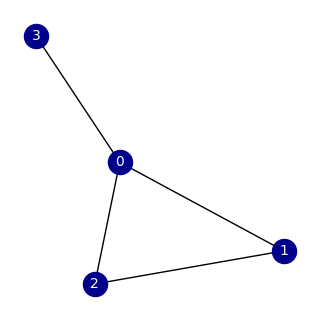

In [2]:
G = nx.connected_watts_strogatz_graph(n=4, k=2, p=0.2, tries=100, seed=312)
# G = nx.erdos_renyi_graph(n=4, p=0.3, seed=42)
# G = nx.barabasi_albert_graph(n=8,m=2)
plt.figure(figsize=(3, 3))
nx.draw(
    G,
    with_labels=True,
    node_color="darkblue",
    edge_color="black",
    font_color="white",
    font_size=10,
)

In [3]:
N = len(G.nodes())
num_qubits = int(np.ceil(np.log2(N)))
print("number of nodes=", N, "number of required qubits=", num_qubits)

number of nodes= 4 number of required qubits= 2


In [4]:
def get_edges_of_node(G, i):
    return [j for j in G.neighbors(i)]


# DEGREE_LIST = np.zeros(N)
# for i in range(N):
#    DEGREE_LIST[i] = len(get_edges_of_node(G, i))


def inner_degree(G, num_qubits, i):
    l_array = np.zeros(2**num_qubits)
    neighbors_list = get_edges_of_node(G, i)
    k = len(neighbors_list)
    for j in neighbors_list:
        l_array[j] = 1
    return l_array / k

In [5]:
@qfunc
def prepare_initial_state(x: QNum[num_qubits], y: QNum[num_qubits]):
    if N == 2**num_qubits:
        hadamard_transform(x)
    else:
        prob_array = np.ones(2**num_qubits) / N
        prob_array[N : 2**num_qubits] = 0
        inplace_prepare_state(prob_array.tolist(), 0.0, x)
    for i in range(N):
        control(
            x == i,
            lambda: inplace_prepare_state(
                inner_degree(G, num_qubits, i).tolist(), 0.0, y
            ),
        )


@qfunc
def my_coin(x: QNum[num_qubits], y: QNum[num_qubits]):
    for i in range(N):
        control(
            x == i,
            stmt_block=lambda: grover_diffuser(
                lambda y: inplace_prepare_state(
                    inner_degree(G, num_qubits, i).tolist(), 0.0, y
                ),
                y,
            ),
        )


@qfunc
def my_shift(x: QNum[num_qubits], y: QNum[num_qubits]):
    multiswap(x, y)


@qfunc
def discrete_quantum_walk(
    time: CInt,
    coin_qfuncs: QCallable[QNum, QNum],
    shift_qfuncs: QCallable[QNum, QNum],
    x: QNum,
    y: QNum,
):
    power(
        time,
        lambda: (
            coin_qfuncs(x, y),
            shift_qfuncs(x, y),
        ),
    )

In [6]:
# quantum walk steps
t = 3


@qfunc
def main(x: Output[QNum[num_qubits]]):
    y = QNum("y", num_qubits)
    allocate(num_qubits, x)
    allocate(num_qubits, y)
    prepare_initial_state(x, y)
    discrete_quantum_walk(t, my_coin, my_shift, x, y)
    drop(y)


qprog = synthesize(main)
write_qmod(main, decimal_precision=15, name="dt_quantumwalk_complex_network")
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36psaY4uUAB0FUaKitHGFwf28f5


In [7]:
execution_job = execute(qprog)
result = execution_job.result_value()

<Axes: xlabel='x'>

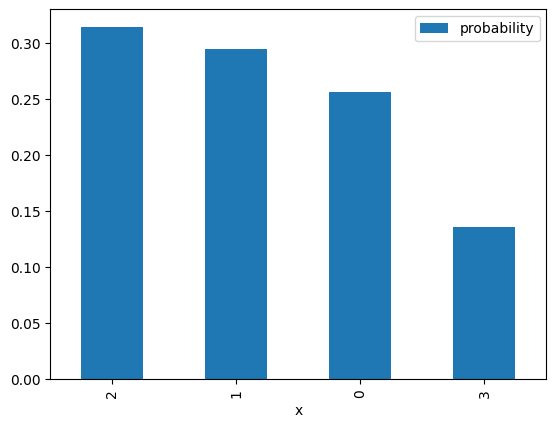

In [8]:
result.dataframe.plot.bar(x="x", y="probability")